# Universal quantum classifier

**Author: Shahnawaz Ahmed (shahnawaz.ahmed95@gmail.com)**

A single-qubit quantum circuit which can implement arbitrary unitary operations can be used as a universal classifier much like a single hidden-layered Neural Network. As surprising as it sounds, Adri´an P´erez-Salinas et al. (2019) discuss this with their idea of ´data reuploading´. It is possible to load a single qubit with arbitrary dimensional data and use it as a universal classifier.

In this example, we will implement this idea with `Pennylane` - a python based tool for quantum machine learning, automatic differentiation, and optimization of hybrid quantum-classical computations.


### Circles

We consider a simple classification problem will train a single-qubit variational quantum circuit to achieve this goal. The data is generated as a set of random points in a plane $(x_1, x_2)$ and labeled as 1 (blue) or 0 (red) depending on whether they lie inside or outside a circle. 

![Screenshot 2019-07-22 14 32 38](https://user-images.githubusercontent.com/6968324/61652759-3bd7ea80-aca8-11e9-88c6-9e9f4d443703.png)


### Quantum states, unitaries and data-reuploading

A single-qubit quantum state is characterized by a two-dimensional state vector and can be visualized as a point in the so-called Bloch sphere. Instead of just being a 0 or 1, it can exist as a superposition with say 30% chance of being in the $|0 \rangle$ and 70% chance of being in the $|1 \rangle$ state. This is represented by a state vector $|\psi \rangle = 0.3|0 \rangle + 0.7|0 \rangle $ -  the probability "amplitude" of the quantum state. In general we can take a vector $(\alpha, \beta)$ to represent the probabilities that a qubit can take and visualize it as follows:

![Screenshot 2019-07-22 14 33 49](https://user-images.githubusercontent.com/6968324/61652766-3f6b7180-aca8-11e9-9de5-8efcbd7b63f2.png)

In order to load data onto a single qubit, we use a unitary operation U ($x_1$, $x_2$, $x_3$) which is just a parameterized matrix multiplication representing the rotation of the state vector in the Bloch sphere. Eg., to load $(x_1, x_2)$ into the qubit, we just start from some initial state vector, $|0 \rangle $, apply the unitary operation $U(x_1, x_2, 0)$ and end up at a new point on the Bloch sphere. Here we have padded 0 since our data is only 2D. Adri´an P´erez-Salinas et al. (2019) discuss how to load a higher dimensional data point ($[x_1, x_2, x_3, x_4, x_5, x_6]$) by breaking it down in sets of three parameters ($U(x_1, x_2, x_3), U(x_4, x_5, x_6)$).



### Model parameters and linear layers with data re-uploading

Once we load the data onto the quantum circuit, we want to have some trainable nonlinear model similar to a Neural Network and a way of learning the weights of the model from data. This is again done with unitaries, $U(\theta_1, \theta_2, \theta_3)$ such that we load the data first and then apply the weights to form a single layer $L(\vec \theta, \vec x) = U(\vec \theta)U(\vec x)$. In principle, this is just application of two matrix multiplications on an input vector initialized to some value. In order to increase the number of trainable parameters (similar to increasing neurons in a single layer of a neural network), we can reapply this layer again and again with new sets of weights, $L(\vec \theta_1, \vec x) L(\vec \theta_2, , \vec x) ... L(\vec \theta_L, \vec x)$ for $L$ layers. The quantum circuit would look like the following:

![Screenshot 2019-07-22 14 49 40](https://user-images.githubusercontent.com/6968324/61652768-41353500-aca8-11e9-819a-8b40380e7dfa.png)



### Nonlinear "collapse" and the cost function

So far, we have only performed linear operations (matrix multiplications) and we know that we need to have some nonlinear squashing similar to activation functions in neural networks to really make a universal classifier (Cybenko 1989). Here is where things gets a bit quantum. After the application of the layers, we will end up at some point on the Bloch sphere due to the sequence of unitaries implementing rotations of the input. These are still just linear transformations of the input state. Now, the output of the model should be a class label which can be encoded as fixed vectors (Blue = $[1, 0]$, Red = $[0, 1]$) on the Bloch sphere. We want to end up at either of them after transforming our input state through alternate applications of data layer and weights. 

We can use the idea of the "collapse" of our quantum state state into one or other class. This happens when we measure the quantum state which leads to its projection as either the state 0 or 1. We can compute the fidelity (or closeness) of the output state to the class label making the output state jump to either $| 0 \rangle or |1\rangle$. By repeating this process several times, we can compute the probability or overlap and assign a label based on which label state, our output has a higher overlap.

<img width="1021" alt="Screenshot 2019-07-22 16 47 50" src="https://user-images.githubusercontent.com/6968324/61652769-42666200-aca8-11e9-918e-c7ab5a503a9a.png">

We can then define the cost function as the sum of the fidelities for all the data points and optimize the parameters $(\vec \theta)$ to reduce the cost and get a trained model which can make the classification for new data points.

$$
\texttt{Cost} = \sum_{\texttt{data points}} (1 - \texttt{fidelity}(\psi_{\texttt{output}}(\vec x, \vec \theta), \psi_{\texttt{label}}))
$$

Now, we can use our favorite optimizer to maximize the sum of the fidelities over all data points (or batches of datapoints) and find the optimal weights for classification.

In `pennylane`, we can define an observable (the expected output label) and make a circuit to return the fidelity using the `Hermitian` operator.

### Multiple qubits, entanglement and Deep Neural Networks

The Universal Approximation Theorem declares a single hidden layered neural network to be capable of approximating any function to arbitrary accuracy. But in practice, it might require a large number of neurons in the single hidden layer and here is where Deep Neural Networks come into action. Deep Neural Networks proved to be better in practice and we have some intuitive idea why, read "Why does deep and cheap learning work so well?" by Henry W. Lin, Max Tegmark (MIT) and David Rolnick (2016).

Adri´an P´erez-Salinas et al. (2019) describe that in their approach the "layers" $L_i(\vec \theta_i, \vec x )$ are analogous to the size of the intermediate hidden layer of the neural network. And what counts for deep (multiple layers of the neural network) relates to the number of qubits. So, multiple qubits with entanglement between them could provide some quantum advantage over classical neural networks. But here, we will only implement a single qubit classifier.

<img width="1088" alt="Screenshot 2019-07-22 17 16 22" src="https://user-images.githubusercontent.com/6968324/61652774-43978f00-aca8-11e9-972e-8d13208055f2.png">

## "Talk is cheap. Show me the code."
### - Linus Torvalds

In [1]:
import pennylane as pl
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

from sklearn.metrics import accuracy_score
from qutip import Qobj, fidelity, Bloch

import matplotlib.pyplot as plt
%matplotlib inline

/home/doniyor/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/doniyor/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/doniyor/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/doniyor/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

ModuleNotFoundError: No module named 'qutip'

# Make a dataset of points in and out of a circle

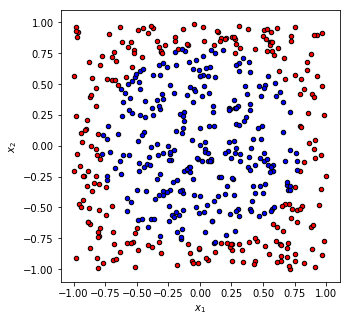

In [2]:
def circle(samples, center=[0., 0.], radius=0.8):
    """
    Generates a dataset of points with 1/0 labels inside a given radius. 
    
    Parameters
    ----------
    samples: int
        The number of samples to generate.
        
    center: tuple
        The center of the circle
        
    radius: float
        The radius of the circle.
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2*(np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1 
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.
    
    Parameters
    ----------
    x: ndarray (m, 2)
        An array of m data points with each having dimension 2
        
    y: ndarray (m)
        An array of labels as int (0/1).
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5,5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red",
                s=20, edgecolor='k')
    ax.scatter(x[blues, 0], x[blues, 1], c="blue",
                s=20, edgecolor='k')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = circle(500)
plot_data(Xdata, ydata)

# Define output labels as quantum state vectors

In [3]:
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector
    Returns:
        dm: (array[complex]): array representing the density matrix.
    """
    return state*np.conj(state).T

label_0 = [[1.0 + 0.j],
           [0. + 0.j]]

label_1 = [[0. + 0.j],
           [1. + 0.j]]

state_labels = [label_0, label_1]

# Make a simple classifier data reloading circuit

In [4]:
dev = pl.device('default.qubit', wires=1)
# Use your own pennylane-plugin to run on some particular backend

@pl.qnode(dev)
def qcircuit(var, x=None, y=None):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        var (array[float]): array of variables
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for v in var:
        pl.Rot(*x, wires=0)
        pl.Rot(*v, wires=0)
    return pl.expval(pl.Hermitian(y, wires=[0]))


def fidelity(state1, state2):
    """
    Calculates the fidelity between two state vectors

    Args:
        state1 (array[float]): State vector representation
        state2 (array[float]): State vector representation

    Returns:
        float: fidelity between `state1` and `state2`
    """
    return np.abs(np.dot(np.conj(state1), state2))

    
def cost(weights, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        weights (array[float]): array of weights
        x (array[float]): 2-d array of input vectors.
        y (array[float]): 1-d array of targets.
        state_labels (array[float]): array of state representations for labels
        
    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(weights, x=x[i], y=dm_labels[y[i]])
        loss = loss + (1 - f)
    return loss/len(x)

In [5]:
def test(weights, x, y, state_labels=None):
    """
    Tests on a given set of data.
    
    Args:
        weights (array[float]): array of weights
        x (array[float]): 2-d array of input vectors.
        y (array[float]): 1-d array of targets.
        state_labels (array[float]): 1-d array of state representations for labels
        
    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    output_states = []
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        expectation = qcircuit(weights, x=x[i], y=dm_labels[y[i]])
        output_states.append(dev._state)
    predicted = predicted_labels(output_states, state_labels)
    return predicted, output_states


def predicted_labels(states, state_labels=None):
    """
    Computes the label of the predicted state by selecting the one
    with maximum fidelity
    
    Args:
        weights (array[float]): array of weights
        x (array[float]): 2-d array of input vectors.
        y (array[float]): 1-d array of targets.
        state_labels (array[float]): 1-d array of state representations for labels
        
    Returns:
        float: loss value to be minimized
    """
    output_labels = [np.argmax([fidelity(s, label) for label in state_labels]) for s in states]
    return np.array(output_labels)

In [6]:
def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets.
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score : float
            The fraction of correctly classified samples.
    """
    score = y_true == y_pred
    return score.sum()/len(y_true)

In [7]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data
    
    Args:
        inputs (array[float]): input data
        targets (array[float]): targets
    
    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

# Generate training and test data

In [8]:
num_training = 200
num_test = 500

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1))))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1))))

# Train and evaluate the classifier using gradient descent

In [10]:
num_layers = 3
learning_rate = 0.1
epochs = 10
batch_size = 20

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
weights = np.random.random(size=(num_layers, 3))

predicted_train, states_train = test(weights, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)
    
predicted_test, states_test = test(weights, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

loss = cost(weights, X_test, y_test, state_labels)

print("Epoch: {:2d} | Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(0,
                                                                                       loss[0],
                                                                                       accuracy_train,
                                                                                       accuracy_test))
for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        weights = opt.step(lambda v: cost(v, Xbatch, ybatch, state_labels), weights)
    
    predicted_train, states_train = test(weights, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(weights, X_train, y_train, state_labels)    

    predicted_test, states_test = test(weights, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)

    print("Epoch: {:2d} | Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(it + 1,
                                                                                       loss[0],
                                                                                       accuracy_train,
                                                                                       accuracy_test))

Epoch:  0 | Cost: 0.509948 | Train accuracy 0.515000 | Test Accuracy : 0.508000
Epoch:  1 | Cost: 0.430845 | Train accuracy 0.605000 | Test Accuracy : 0.654000
Epoch:  2 | Cost: 0.353277 | Train accuracy 0.730000 | Test Accuracy : 0.748000
Epoch:  3 | Cost: 0.306970 | Train accuracy 0.765000 | Test Accuracy : 0.790000
Epoch:  4 | Cost: 0.295256 | Train accuracy 0.820000 | Test Accuracy : 0.808000
Epoch:  5 | Cost: 0.294993 | Train accuracy 0.805000 | Test Accuracy : 0.792000
Epoch:  6 | Cost: 0.293592 | Train accuracy 0.805000 | Test Accuracy : 0.790000
Epoch:  7 | Cost: 0.291759 | Train accuracy 0.815000 | Test Accuracy : 0.804000
Epoch:  8 | Cost: 0.290740 | Train accuracy 0.830000 | Test Accuracy : 0.808000
Epoch:  9 | Cost: 0.289939 | Train accuracy 0.820000 | Test Accuracy : 0.810000
Epoch: 10 | Cost: 0.289068 | Train accuracy 0.830000 | Test Accuracy : 0.808000


# Results

Number of training data points: 200; Number of test data points: 500
Total number of calls to circuit for training: 2000
Number of times model parameters were updated: 100
Cost: 0.289068 | Train accuracy 0.830000 | Test Accuracy : 0.808000


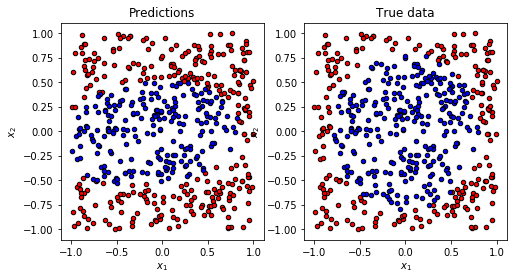

In [13]:
print("==========================================================================")
print("Number of training data points: {}; Number of test data points: {}".format(len(X_train), len(X_test)))
print("Total number of calls to circuit for training: {}".format(int(len(X_train)*epochs)))
print("Number of times model parameters were updated: {:2d}".format(int(len(X_train)*epochs/batch_size)))
print("Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(loss[0],
                                                                          accuracy_train,
                                                                          accuracy_test))
print("==========================================================================")

fig, axes = plt.subplots(1, 2, figsize = (8, 4))
plot_data(X_test, predicted_test, fig, axes[0])
plot_data(X_test, y_test,  fig, axes[1])
axes[0].set_title("Predictions")
axes[1].set_title("True data")
plt.show()

# References

[1] Pérez-Salinas, Adrián, et al. "Data re-uploading for a universal quantum classifier." arXiv preprint arXiv:1907.02085 (2019).